In [1]:
import numpy as np  # linear algebra
import pandas as pd  # read and wrangle dataframes
import matplotlib.pyplot as plt # visualization
import seaborn as sns # statistical visualizations and aesthetics
from sklearn.base import TransformerMixin # To create new classes for transformations
from sklearn.preprocessing import (FunctionTransformer, StandardScaler) # preprocessing 
from sklearn.decomposition import PCA # dimensionality reduction
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.stats import boxcox # data transform
from sklearn.model_selection import (train_test_split, KFold , StratifiedKFold, 
                                     cross_val_score, GridSearchCV, 
                                     learning_curve, validation_curve) # model selection modules
from sklearn.pipeline import Pipeline # streaming pipelines
from sklearn.base import BaseEstimator, TransformerMixin # To create a box-cox transformation class
from collections import Counter
import warnings
# load models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import (XGBClassifier, plot_importance)
from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from time import time

%matplotlib inline 
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [2]:
data = pd.read_csv('glass.csv')
features = data.columns[:-1].tolist()
print(data.shape)

(214, 10)


In [3]:
data['Type'].value_counts()

2    76
1    70
7    29
3    17
5    13
6     9
Name: Type, dtype: int64

In [4]:
# Detect observations with more than one outlier

def outlier_hunt(data):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers. 
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in data.columns.tolist():
        # 1st quartile (25%)
        Q1 = np.percentile(data[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(data[col],75)
        
        # Interquartile rrange (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = data[(data[col] < Q1 - outlier_step) | (data[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers   

print('The dataset contains %d observations with more than 2 outliers' %(len(outlier_hunt(data[features]))))   

The dataset contains 14 observations with more than 2 outliers


In [5]:
outlier_indices = outlier_hunt(data[features])
data = data.drop(outlier_indices).reset_index(drop=True)
print(data.shape)

(200, 10)


In [6]:
data['Type'].value_counts()

2    70
1    70
7    25
3    17
5    10
6     8
Name: Type, dtype: int64

In [7]:
# Define X as features and y as lablels
X = data[features] 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
y = data['Type'] 
# set a seed and a test size for splitting the dataset 
seed = 7
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size , random_state = seed)

In [8]:
features_boxcox = []

for feature in features:
    bc_transformed, _ = boxcox(data[feature]+1)  # shift by 1 to avoid computing log of negative values
    features_boxcox.append(bc_transformed)

features_boxcox = np.column_stack(features_boxcox)
data_bc = pd.DataFrame(data=features_boxcox, columns=features)
data_bc['Type'] = data['Type']

In [9]:
for feature in features:
    delta = np.abs( data_bc[feature].skew() / data[feature].skew() )
    if delta < 1.0 :
        print('Feature %s is less skewed after a Box-Cox transform' %(feature))
    else:
        print('Feature %s is more skewed after a Box-Cox transform'  %(feature))

Feature RI is less skewed after a Box-Cox transform
Feature Na is less skewed after a Box-Cox transform
Feature Mg is less skewed after a Box-Cox transform
Feature Al is less skewed after a Box-Cox transform
Feature Si is less skewed after a Box-Cox transform
Feature K is less skewed after a Box-Cox transform
Feature Ca is less skewed after a Box-Cox transform
Feature Ba is less skewed after a Box-Cox transform
Feature Fe is less skewed after a Box-Cox transform


Elapsed time to train XGBoost  0.167 seconds


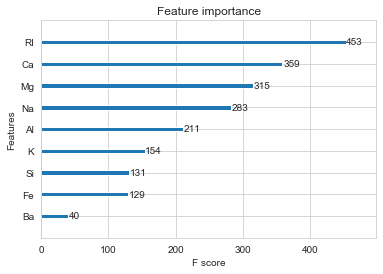

In [10]:
model_importances = XGBClassifier()
start = time()
model_importances.fit(X_train, y_train)
print('Elapsed time to train XGBoost  %.3f seconds' %(time()-start))
plot_importance(model_importances)
plt.show()

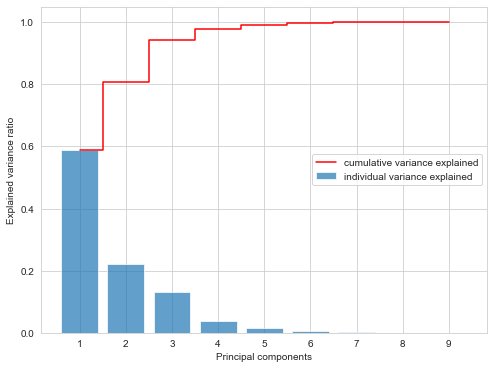

In [11]:
pca = PCA(random_state = seed)
pca.fit(X_train)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
plt.figure(figsize=(8,6))
plt.bar(range(1,len(cum_var_exp)+1), var_exp, align= 'center', label= 'individual variance explained', \
       alpha = 0.7)
plt.step(range(1,len(cum_var_exp)+1), cum_var_exp, where = 'mid' , label= 'cumulative variance explained', \
        color= 'red')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.xticks(np.arange(1,len(var_exp)+1,1))
plt.legend(loc='center right')
plt.show()



In [12]:
from sklearn.naive_bayes import GaussianNB
classifier_nb = GaussianNB()
classifier_nb.fit(X_train, y_train.ravel())

GaussianNB()

In [13]:
y_pred_nb_train = classifier_nb.predict(X_train)
accuracy_nb_train = accuracy_score(y_train, y_pred_nb_train)
print("Training set: ", accuracy_nb_train)

y_pred_nb_test = classifier_nb.predict(X_test)
accuracy_nb_test = accuracy_score(y_test, y_pred_nb_test)
print("Test set: ", accuracy_nb_test)

Training set:  0.31875
Test set:  0.325


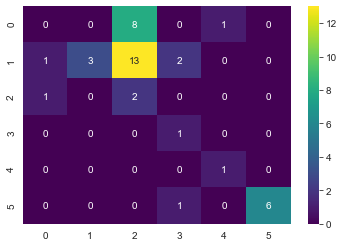

In [14]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred_nb_test), annot=True, cmap = 'viridis', fmt='.0f')
plt.show()

In [15]:
from sklearn.svm import SVC
classifier_svm = SVC()
steps = [
    ('scalar', StandardScaler()),
    ('model', SVC())
]
svm_linear_pipe = Pipeline(steps)

In [16]:
parameters = { 'model__kernel' : ['linear'],
               'model__C' : [1,10,100,1000,10000],
               'model__random_state' : [42]
}
classifier_svm_linear = GridSearchCV(svm_linear_pipe, parameters, iid=False, cv = 3)
classifier_svm_linear = classifier_svm_linear.fit(X_train, y_train.ravel())

In [17]:
y_pred_svm_linear_train = classifier_svm_linear.predict(X_train)
accuracy_svm_linear_train = accuracy_score(y_train, y_pred_svm_linear_train)
print("Training set: ", accuracy_svm_linear_train)

y_pred_svm_linear_test = classifier_svm_linear.predict(X_test)
accuracy_svm_linear_test = accuracy_score(y_test, y_pred_svm_linear_test)
print("Test set: ", accuracy_svm_linear_test)

Training set:  0.80625
Test set:  0.675


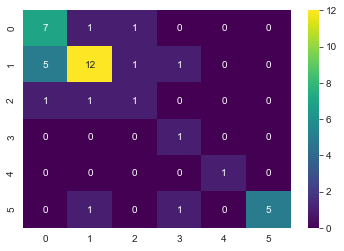

In [18]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred_svm_linear_test), annot=True, cmap = 'viridis', fmt='.0f')
plt.show()

In [19]:
# Fitting classifier to the Training set
from sklearn.svm import SVC
classifier_svm_kernel = SVC()
steps = [
    ('scalar', StandardScaler()),
    ('model', SVC())
]
svm_kernel_pipe = Pipeline(steps)

In [20]:
parameters = { 'model__kernel' : ['rbf', 'poly', 'sigmoid'],
               'model__C' : [1,10,100,1000,10000],
               'model__gamma' : [0.001, 0.01, 0.1, 1, 'scale'],
               'model__random_state' : [42],
               'model__degree' : [1,2,3]
}
classifier_svm_kernel = GridSearchCV(svm_kernel_pipe, parameters, iid=False, cv = 3)
classifier_svm_kernel = classifier_svm_kernel.fit(X_train, y_train.ravel())

In [21]:
y_pred_svm_kernel_train = classifier_svm_kernel.predict(X_train)
accuracy_svm_kernel_train = accuracy_score(y_train, y_pred_svm_kernel_train)
print("Training set: ", accuracy_svm_kernel_train)

y_pred_svm_kernel_test = classifier_svm_kernel.predict(X_test)
accuracy_svm_kernel_test = accuracy_score(y_test, y_pred_svm_kernel_test)
print("Test set: ", accuracy_svm_kernel_test)

Training set:  0.91875
Test set:  0.625


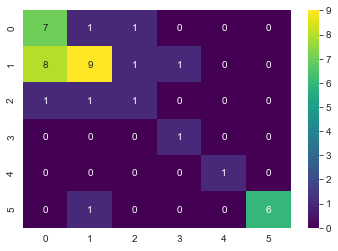

In [22]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred_svm_kernel_test), annot=True, cmap = 'viridis', fmt='.0f')
plt.show()

In [23]:
# Fitting classifier to the Training set
from sklearn.neighbors import KNeighborsClassifier
classifier_knn = KNeighborsClassifier()
steps = [
    ('scalar', StandardScaler()),
    ('model', KNeighborsClassifier())
]
knn_pipe = Pipeline(steps)

In [24]:
parameters = { 'model__algorithm' : ['brute'],
               'model__leaf_size' : [30,50,70,90,110],
               'model__metric' : ['minkowski'],
               'model__p' : [1],
               'model__n_neighbors' : [3,5,11,19],
               'model__weights' : ['uniform', 'distance'],
               'model__n_jobs' : [-1]
}
classifier_knn = GridSearchCV(knn_pipe, parameters, iid=False, cv = 3)
classifier_knn = classifier_knn.fit(X_train, y_train.ravel())

In [25]:
y_pred_knn_train = classifier_knn.predict(X_train)
accuracy_knn_train = accuracy_score(y_train, y_pred_knn_train)
print("Training set: ", accuracy_knn_train)

y_pred_knn_test = classifier_knn.predict(X_test)
accuracy_knn_test = accuracy_score(y_test, y_pred_knn_test)
print("Test set: ", accuracy_knn_test)

Training set:  1.0
Test set:  0.7


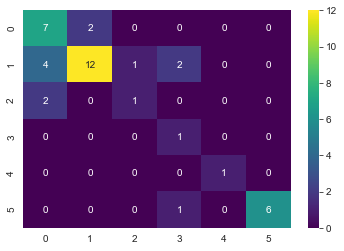

In [26]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred_knn_test), annot=True, cmap = 'viridis', fmt='.0f')
plt.show()

In [27]:
# Fitting classifier to the Training set
from sklearn.tree import DecisionTreeClassifier
classifier_dt = DecisionTreeClassifier()

steps = [
    ('scalar', StandardScaler()),
    ('model', DecisionTreeClassifier())
]
dt_pipe = Pipeline(steps)

In [28]:
# Applying Grid Search to find the best model and the best parameters
parameters = [ { "model__max_depth": np.arange(1,21),
                 "model__min_samples_leaf": [1, 5, 10, 20, 50, 100],
                 "model__min_samples_split": np.arange(2, 11),
                 "model__criterion": ["gini"],
                 "model__random_state" : [42]}
            ]
classifier_dt = GridSearchCV(estimator = dt_pipe,
                           param_grid  = parameters,
                           cv = 3,
                           iid = False,
                           n_jobs = -1)
classifier_dt = classifier_dt.fit(X_train, y_train.ravel())

In [29]:
y_pred_dt_train = classifier_dt.predict(X_train)
accuracy_dt_train = accuracy_score(y_train, y_pred_dt_train)
print("Training set: ", accuracy_dt_train)

y_pred_dt_test = classifier_dt.predict(X_test)
accuracy_dt_test = accuracy_score(y_test, y_pred_dt_test)
print("Test set: ", accuracy_dt_test)

Training set:  0.7375
Test set:  0.675


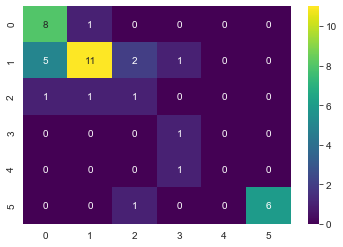

In [30]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred_dt_test), annot=True, cmap = 'viridis', fmt='.0f')
plt.show()

In [31]:
# Fitting Logistic Regression to the Training set
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

classifier_lr = LogisticRegression()
steps = [
    ('scalar', StandardScaler()),
    ('model', LogisticRegression())
]

lr_pipe = Pipeline(steps)

In [32]:
parameters = { 'model__C' : [1,10,100,1000,10000],
               'model__fit_intercept' : [True],
               'model__multi_class' : ['auto'],
               'model__tol' : [0.0001],
               'model__solver' : ['newton-cg', 'lbfgs', 'sag', 'saga'],
               'model__n_jobs' : [-1],
               'model__max_iter' : [5000],
               'model__random_state': [42] 
}
classifier_lr = GridSearchCV(lr_pipe, parameters, iid=False, cv = 3)
classifier_lr = classifier_lr.fit(X_train, y_train.ravel())

In [33]:
from sklearn.metrics import accuracy_score

y_pred_lr_train = classifier_lr.predict(X_train)
accuracy_lr_train = accuracy_score(y_train, y_pred_lr_train)
print("Training set: ", accuracy_lr_train)

y_pred_lr_test = classifier_lr.predict(X_test)
accuracy_lr_test = accuracy_score(y_test, y_pred_lr_test)
print("Test set: ", accuracy_lr_test)

Training set:  0.76875
Test set:  0.675


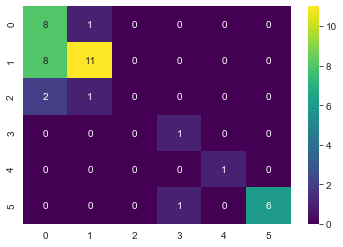

In [34]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred_lr_test), annot=True, cmap = 'viridis', fmt='.0f')
plt.show()

In [35]:
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, y_train.ravel())
scores = cross_val_score(clf, X_train, y_train.ravel(), cv=10)
scores.mean()

0.74375

In [36]:
y_pred_clf_train = clf.predict(X_train)
accuracy_clf_train = accuracy_score(y_train, y_pred_clf_train)
print("Training set: ", accuracy_clf_train)

y_pred_clf_test = clf.predict(X_test)
accuracy_clf_test = accuracy_score(y_test, y_pred_clf_test)
print("Test set: ", accuracy_clf_test)

Training set:  0.9875
Test set:  0.725


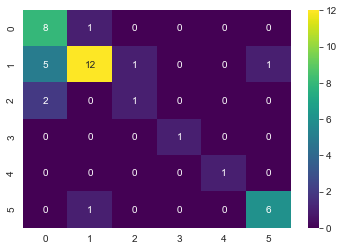

In [37]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred_clf_test), annot=True, cmap = 'viridis', fmt='.0f')
plt.show()

In [38]:
etc = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
etc = etc.fit(X_train, y_train.ravel())

In [39]:
y_pred_etc_train = clf.predict(X_train)
accuracy_etc_train = accuracy_score(y_train, y_pred_etc_train)
print("Training set: ", accuracy_etc_train)

y_pred_etc_test = etc.predict(X_test)
accuracy_etc_test = accuracy_score(y_test, y_pred_etc_test)
print("Test set: ", accuracy_etc_test)

Training set:  0.9875
Test set:  0.675


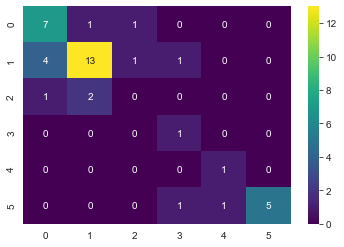

In [40]:
sns.heatmap(confusion_matrix(y_test, y_pred_etc_test), annot=True, cmap = 'viridis', fmt='.0f')
plt.show()

In [41]:
adb = AdaBoostClassifier(n_estimators=100)
adb = adb.fit(X_train, y_train.ravel())

In [42]:
y_pred_adb_train = adb.predict(X_train)
accuracy_adb_train = accuracy_score(y_train, y_pred_adb_train)
print("Training set: ", accuracy_adb_train)

y_pred_adb_test = adb.predict(X_test)
accuracy_adb_test = accuracy_score(y_test, y_pred_adb_test)
print("Test set: ", accuracy_adb_test)

Training set:  0.48125
Test set:  0.425


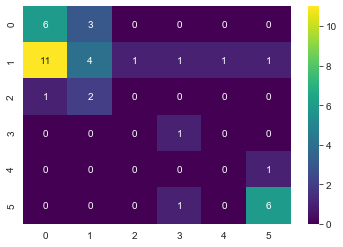

In [43]:
sns.heatmap(confusion_matrix(y_test, y_pred_adb_test), annot=True, cmap = 'viridis', fmt='.0f')
plt.show()

In [44]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train.ravel())

In [45]:
y_pred_gbc_train = gbc.predict(X_train)
accuracy_gbc_train = accuracy_score(y_train, y_pred_gbc_train)
print("Training set: ", accuracy_adb_train)

y_pred_gbc_test = gbc.predict(X_test)
accuracy_gbc_test = accuracy_score(y_test, y_pred_gbc_test)
print("Test set: ", accuracy_gbc_test)

Training set:  0.48125
Test set:  0.65


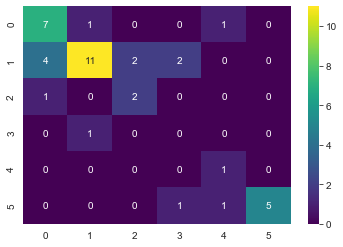

In [46]:
sns.heatmap(confusion_matrix(y_test, y_pred_gbc_test), annot=True, cmap = 'viridis', fmt='.0f')
plt.show()

In [47]:
models = [('Logistic Regression', accuracy_lr_train, accuracy_lr_test),
          ('KNN', accuracy_knn_train, accuracy_knn_test),
          ('SVM (Linear)', accuracy_svm_linear_train, accuracy_svm_linear_test),
          ('SVM (Kernel)', accuracy_svm_kernel_train, accuracy_svm_kernel_test),
          ('Naive Bayes', accuracy_nb_train, accuracy_nb_test),
          ('Decision Tree Classification', accuracy_dt_train, accuracy_dt_test),
          ('Random Forest Ensemble', accuracy_clf_train, accuracy_clf_test),
          ('Extremely Randomized Tress', accuracy_etc_train, accuracy_etc_test),
         ('AdaBoost', accuracy_adb_train, accuracy_adb_test),
          ('Gradient Tree Boosting', accuracy_gbc_train, accuracy_gbc_test)
         ]

In [48]:
predict = pd.DataFrame(data = models, columns=['Model', 'Training Accuracy', 'Test Accuracy'])
predict

,Model,Training Accuracy,Test Accuracy
0,Logistic Regression,0.76875,0.675
1,KNN,1.00000,0.700
2,SVM (Linear),0.80625,0.675
3,SVM (Kernel),0.91875,0.625
4,Naive Bayes,0.31875,0.325
5,Decision Tree Classification,0.73750,0.675
6,Random Forest Ensemble,0.98750,0.725
7,Extremely Randomized Tress,0.98750,0.675
8,AdaBoost,0.48125,0.425
9,Gradient Tree Boosting,0.98750,0.650


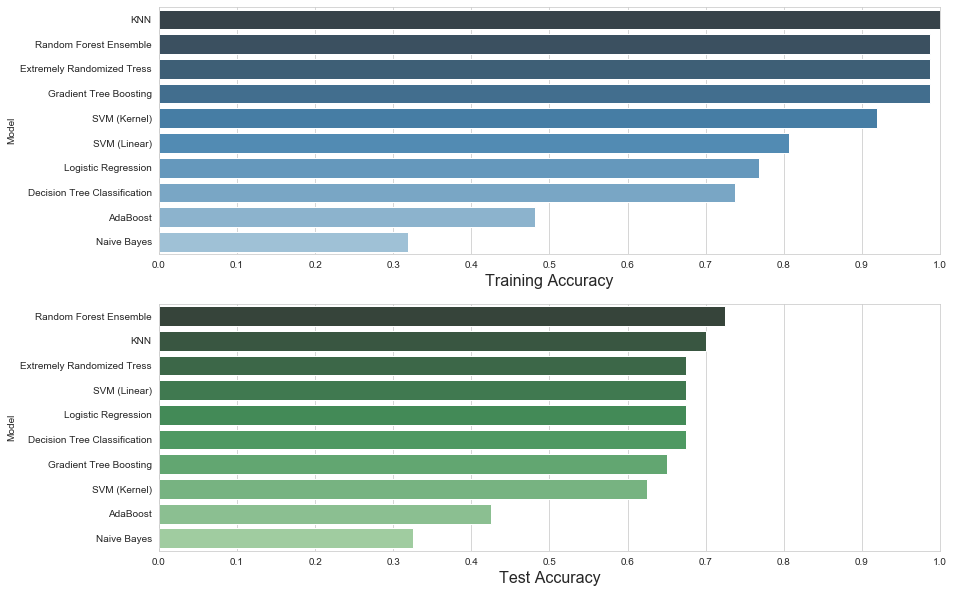

In [49]:
f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['Training Accuracy'], ascending=False, inplace=True)

sns.barplot(x='Training Accuracy', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('Training Accuracy', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)
axes[0].set_xticks(np.arange(0, 1.1, 0.1))

predict.sort_values(by=['Test Accuracy'], ascending=False, inplace=True)

sns.barplot(x='Test Accuracy', y='Model', data = predict, palette='Greens_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('Test Accuracy', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)
axes[1].set_xticks(np.arange(0, 1.1, 0.1))

plt.show()